# Scikit-Learn Model


In [9]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch

from transformers import AutoTokenizer, AutoModel

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from xgboost import XGBClassifier


In [10]:

# Load the dataset
df = pd.read_csv('../../data/output/eicu.csv')

TEXT_COLS = "lab_results"
TARGET_COL = "diagnosis"
ENCODER_MODEL_NAME = "dmis-lab/biobert-base-cased-v1.1"

In [11]:

tokenizer = AutoTokenizer.from_pretrained(ENCODER_MODEL_NAME)
model = AutoModel.from_pretrained(ENCODER_MODEL_NAME)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

def embed_texts(texts, batch_size=32, max_length=256, pooling="mean"):
    """
    texts: list[str]
    returns: np.ndarray of shape (len(texts), hidden_size) e.g., (N, 768)
    """
    all_vecs = []
    with torch.no_grad():
        for i in range(0, len(texts), batch_size):
            batch = texts[i:i+batch_size]
            enc = tokenizer(
                batch,
                padding=True,
                truncation=True,
                max_length=max_length,
                return_tensors="pt"
            )
            enc = {k: v.to(device) for k, v in enc.items()}
            out = model(**enc)  # last_hidden_state: (B, T, H)
            last_hidden = out.last_hidden_state

            if pooling == "cls":
                vecs = last_hidden[:, 0, :]                       # (B, H) [CLS]
            else:  # mean pooling over valid tokens
                attn = enc["attention_mask"].unsqueeze(-1)        # (B, T, 1)
                summed = (last_hidden * attn).sum(dim=1)          # (B, H)
                counts = attn.sum(dim=1).clamp(min=1e-9)          # (B, 1)
                vecs = summed / counts                            # (B, H)

            vecs = vecs.detach().cpu().numpy()
            all_vecs.append(vecs)
    return np.vstack(all_vecs)


Loading weights: 100%|██████████| 199/199 [00:00<00:00, 1293.29it/s, Materializing param=pooler.dense.weight]                               
BertModel LOAD REPORT from: dmis-lab/biobert-base-cased-v1.1
Key                                        | Status     |  | 
-------------------------------------------+------------+--+-
cls.seq_relationship.weight                | UNEXPECTED |  | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED |  | 
cls.seq_relationship.bias                  | UNEXPECTED |  | 
cls.predictions.transform.dense.weight     | UNEXPECTED |  | 
cls.predictions.decoder.bias               | UNEXPECTED |  | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED |  | 
cls.predictions.transform.dense.bias       | UNEXPECTED |  | 
cls.predictions.bias                       | UNEXPECTED |  | 
cls.predictions.decoder.weight             | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical a

In [12]:

# Convert 'age' to numeric, coercing errors to NaN
df['age'] = pd.to_numeric(df['age'], errors='coerce')

# Fill missing values for 'age' and 'admissionheight' with the median
df['age'] = df['age'].fillna(df['age'].median())
df['admissionheight'] = df['admissionheight'].fillna(df['admissionheight'].median())

# ---------------------------
# Encode FEATURES (one-hot) and TARGET (label-encode)
# ---------------------------

# Target as original labels first (string/categorical)
y_raw = df[TARGET_COL].astype(str)

# Label-encode the target
le_y = LabelEncoder()
y = le_y.fit_transform(y_raw)

# One-hot encode feature categoricals (EXCLUDING the target)
categorical_feature_cols = ['gender', 'ethnicity', 'hospitaladmitsource']  # diagnosis excluded
df_features = df.drop(columns=['diagnosis'])  # remove target from features

X = pd.get_dummies(
    df_features,
    columns=categorical_feature_cols,
    drop_first=True,
    dummy_na=False,
    dtype='int8'
)

# Drop non-predictive ID columns
cols_to_drop = [c for c in ['patientunitstayid'] if c in X.columns]
X = X.drop(columns=cols_to_drop)

# ---------------------------
# Train / Test split (stratify recommended for classification)
# ---------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


X_train_texts = X_train[TEXT_COLS].fillna("").tolist()
X_test_texts  = X_test[TEXT_COLS].fillna("").tolist()

X_train_biobert = embed_texts(X_train_texts, batch_size=32, max_length=256, pooling="mean")
X_test_biobert  = embed_texts(X_test_texts,  batch_size=32, max_length=256, pooling="mean")

print(X_train_biobert.shape, X_test_biobert.shape)


other_cols = [c for c in X_train.columns
              if c not in [TEXT_COLS, TARGET_COL, "patientunitstayid"]]

X_train_other = X_train[other_cols].to_numpy(dtype=float, copy=False) if other_cols else None
X_test_other  = X_test[other_cols].to_numpy(dtype=float, copy=False)  if other_cols else None

if X_train_other is not None and X_train_other.size > 0:
    X_train_final = np.hstack([X_train_other, X_train_biobert])
    X_test_final  = np.hstack([X_test_other,  X_test_biobert])
else:
    X_train_final, X_test_final = X_train_biobert, X_test_biobert


# ---------------------------
# XGBoost for multi-class
# ---------------------------
n_classes = len(le_y.classes_)
model = XGBClassifier(
    objective='multi:softprob',
    num_class=n_classes,
    eval_metric="mlogloss",
    tree_method="hist",
    random_state=42,
    n_estimators=600,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,

)

model.fit(X_train_final, y_train)

# Predict on the test set
y_pred = model.predict(X_test_final)

# Evaluate
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, target_names=le_y.classes_)

print(f'Accuracy: {accuracy:.4f}')
print('Classification Report:')
print(report)



(1368, 768) (343, 768)
Accuracy: 0.3965
Classification Report:
                     precision    recall  f1-score   support

       burns/trauma       0.00      0.00      0.00        10
     cardiovascular       0.42      0.87      0.57       126
          endocrine       0.50      0.41      0.45        22
   gastrointestinal       0.33      0.16      0.21        38
infectious diseases       0.00      0.00      0.00        14
         neurologic       0.50      0.03      0.05        35
              other       0.00      0.00      0.00        14
          pulmonary       0.27      0.14      0.18        59
              renal       0.00      0.00      0.00        11
         toxicology       0.30      0.21      0.25        14

           accuracy                           0.40       343
          macro avg       0.23      0.18      0.17       343
       weighted avg       0.33      0.40      0.31       343



/home/alex/data/msc/project/code/env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/alex/data/msc/project/code/env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/alex/data/msc/project/code/env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{me

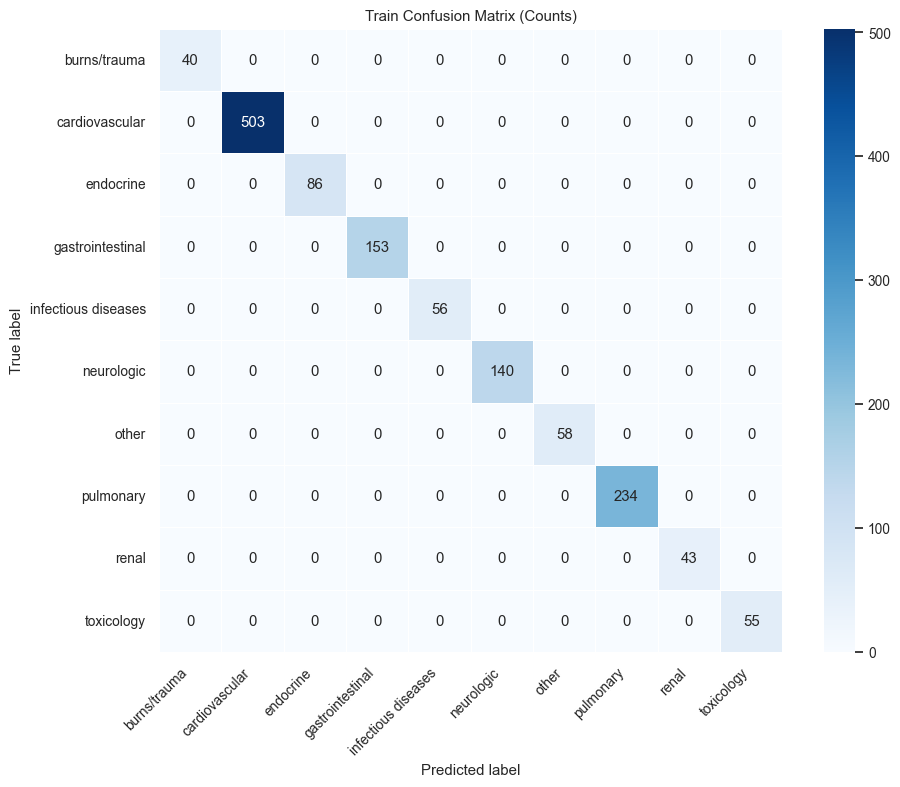

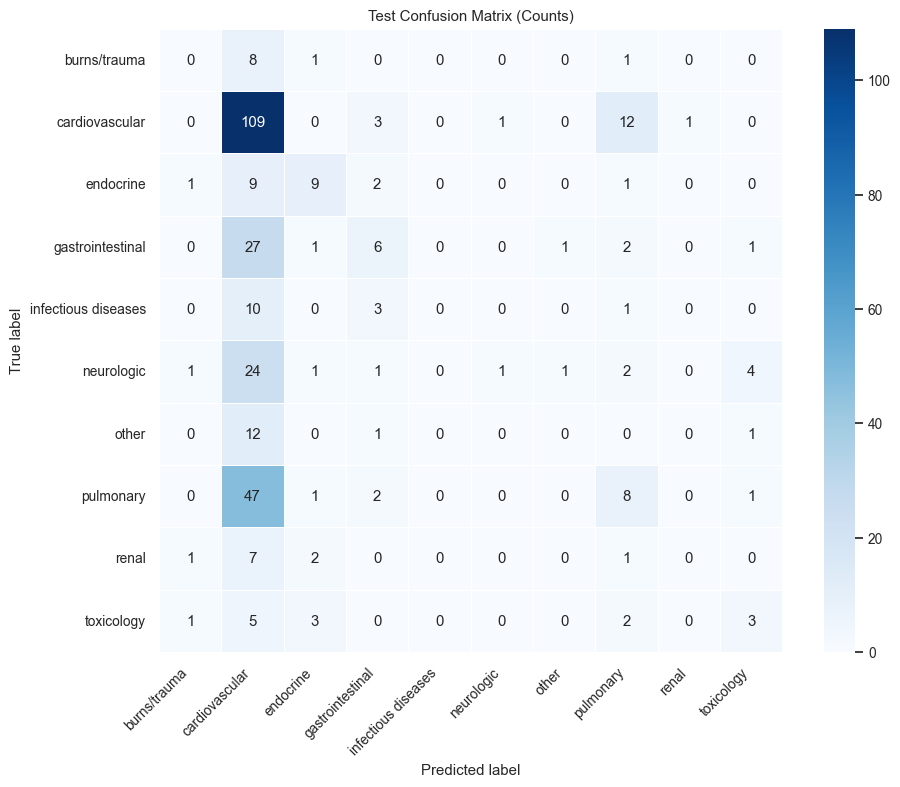

In [13]:

y_pred_train = model.predict(X_train_final)
y_pred_test = model.predict(X_test_final)

sns.set_theme(style="whitegrid", font_scale=0.9)

def plot_confusion_matrix(y_true, y_pred, class_names, title="", normalize=None, figsize=(10, 8), cmap="Blues"):
    """
    normalize: None | 'true' | 'pred' | 'all'
        - None: raw counts
        - 'true': rows sum to 1 (per-actual-class recall-normalized)
        - 'pred': cols sum to 1 (per-predicted-class precision-normalized)
        - 'all': overall normalization
    """
    cm = confusion_matrix(y_true, y_pred, labels=np.arange(len(class_names)), normalize=normalize)
    # If normalized, cm is float; if not, it’s int. Format differently for annotations.
    fmt = ".2f" if normalize else "d"
    cm_df = pd.DataFrame(cm, index=class_names, columns=class_names)

    plt.figure(figsize=figsize)
    ax = sns.heatmap(cm_df, annot=True, fmt=fmt, cmap=cmap, cbar=True,
                     linewidths=0.5, linecolor="white", square=True)
    ax.set_xlabel("Predicted label")
    ax.set_ylabel("True label")
    ax.set_title(title if title else "Confusion Matrix")
    # Rotate x tick labels for readability
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()


plot_confusion_matrix(
    y_train, y_pred_train, class_names=le_y.classes_,
    title="Train Confusion Matrix (Counts)", normalize=None
)
plot_confusion_matrix(
    y_test, y_pred_test, class_names=le_y.classes_,
    title="Test Confusion Matrix (Counts)", normalize=None
)
